## <span style='color:#ff5f27'> 📝 Imports</span>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial
from torch.utils.tensorboard import SummaryWriter

from functions.t5 import encode_text
from functions.vqgan import load_vqgan_model, load_process_encode_rgb_image
import config

2024-09-04 17:15:17,272 INFO: generated new fontManager


## <span style='color:#ff5f27'> 🤖 Model Loading</span>

In [3]:
# Load COCO VQGAN
vqgan_model = load_vqgan_model(
    config.VQGAN_CONFIG_COCO,
    config.VQGAN_CHECKPOINT_COCO,
).to(config.DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-01-20T16-04-20_coco_transformer/coco_cond_stage.ckpt
2024-09-04 17:15:30,979 INFO: number of parameters: 6.513075e+08
Restored from logs/2021-01-20T16-04-20_coco_transformer/model_ckpt/last.ckpt
✅ Done!


## <span style='color:#ff5f27'> ⚙️ Text Encoding</span>

In [4]:
input_text = [
    config.PROMPT,
]

In [5]:
config.PROMPT

'A beautiful sunset over a city skyline.'

In [6]:
text_token_embeds, text_mask = encode_text(
    'A beautiful sunset over a city skyline.', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

torch.Size([39, 3, 1024])

In [7]:
text_token_embeds, text_mask = encode_text(
    'A cat sitting on the coutch', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

torch.Size([27, 3, 1024])

In [8]:
text_token_embeds, text_mask = encode_text(
    'Night rainy city', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

torch.Size([16, 3, 1024])

## <span style='color:#ff5f27'> 🗄️ Data Loader</span>

In [9]:
class TextImageDataset(Dataset):
    def __init__(self, json_file, img_dir, transform=None, min_dim=256):
        with open(json_file, 'r') as f:
            data = json.load(f)
        self.annotations = data['annotations']
        self.img_dir = img_dir
        self.transform = transform
        self.min_dim = min_dim

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_id = ann['image_id']
        caption = ann['caption']
        
        img_name = f"{img_id:012d}.jpg"
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            with Image.open(img_path) as img:
                if min(img.size) < self.min_dim:
                    return None
                image = img.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            return caption, image, img_path
        except (IOError, OSError):
            return None

    def visualize_sample(self, idx):
        item = self[idx]
        if item is None:
            print(f"Unable to visualize sample at index {idx}")
            return

        caption, image_tensor, _ = item
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image_tensor.clone()
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
        
        image = image.numpy().transpose(1, 2, 0)
        image = np.clip(image, 0, 1)
        
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.figtext(0.5, 0.05, caption, wrap=True, horizontalalignment='center', fontsize=12)
        plt.show()

def collate_fn(batch):
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

In [10]:
# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = TextImageDataset(
    json_file='mc_coco/annotations/captions_val2017.json', 
    img_dir='mc_coco/val2017', 
    transform=transform,
)

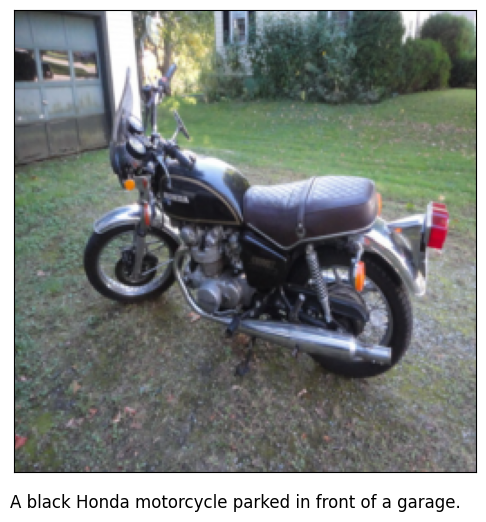

In [11]:
dataset.visualize_sample(0)

In [12]:
# Split the validation dataset into training and validation subsets
train_size = int(0.8 * len(dataset))  # Use 80% for training
val_size = len(dataset) - train_size  # Use 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

### INCREASE BATCH SIZE TO 32

Total dataset size: 25014
Training set size: 20011
Validation set size: 5003




## <span style='color:#ff5f27'> 🧬 Transistor Architecture</span>

In [13]:
class Transistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Transistor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

## <span style='color:#ff5f27'> 🏃🏻‍♂️ Transistor Training</span>

In [14]:
@torch.no_grad()
def preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device):
    text_latents, _ = encode_text_fn(captions)
    text_latents = text_latents.mean(dim=1)  # Average over token dimension

    image_latents = []
    for img_path in img_paths:
        z, _ = load_process_encode_rgb_image(img_path, vqgan_model, device=device)
        image_latents.append(z.view(1, -1))  # Flatten to [1, 256*16*16]
    image_latents = torch.cat(image_latents, dim=0)

    return text_latents.to(device), image_latents.to(device)

In [15]:
@torch.no_grad()
def validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn):
    transistor_model.eval()
    total_loss = 0
    for captions, _, img_paths in val_loader:
        text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
        outputs = transistor_model(text_latents)
        loss = criterion(outputs, image_latents)
        total_loss += loss.item()
    return total_loss / len(val_loader)

def visualize_results(transistor_model, vqgan_model, text_input, device, encode_text_fn):
    transistor_model.eval()
    with torch.no_grad():
        text_latent, _ = encode_text_fn([text_input])
        text_latent = text_latent.mean(dim=1).to(device)
        image_latent = transistor_model(text_latent)
        image = vqgan_model.first_stage_model.decode(image_latent.view(1, 256, 16, 16))
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title(text_input)
    plt.axis('off')
    plt.show()

In [16]:
def train_model(transistor_model, train_loader, val_loader, vqgan_model, criterion, optimizer, device, num_epochs=10, accumulation_steps=4):
    transistor_model.train()
    scaler = torch.cuda.amp.GradScaler()
    encode_text_fn = partial(encode_text, name='t5-large', output_device=device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    writer = SummaryWriter()
    
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, (captions, _, img_paths) in enumerate(pbar):
            text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
            
            with torch.cuda.amp.autocast():
                outputs = transistor_model(text_latents)
                loss = criterion(outputs, image_latents)
            
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i + 1)})
        
        avg_train_loss = running_loss / len(train_loader)
        val_loss = validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(transistor_model.state_dict(), 'best_transistor_model.pth')
            print(f"💾 Saved best model with validation loss: {best_val_loss:.4f}")
        
        if (epoch + 1) % 5 == 0:
            visualize_results(transistor_model, vqgan_model, "A cat sitting on a couch", device, encode_text_fn)
    
    writer.close()
    print("✅ Training completed.")

In [17]:
# Initialize Transistor model
input_dim = 1024  # Dimension of T5 output
hidden_dim = 2048
output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space (assuming 16x16 spatial dimensions)
transistor_model = Transistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

In [18]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(transistor_model.parameters(), lr=0.001, weight_decay=0.01)

In [15]:
# Train the model
train_model(
    transistor_model, 
    train_loader, 
    val_loader, 
    vqgan_model, 
    criterion, 
    optimizer, 
    config.DEVICE, 
    num_epochs=10, 
    accumulation_steps=4,
)

Epoch 1/10:   0%|          | 0/2502 [00:00<?, ?it/s]/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Epoch 1/10: 100%|██████████| 2502/2502 [36:37<00:00,  1.14it/s, loss=0.601]


Epoch [1/10], Train Loss: 0.6009, Val Loss: 0.5985
💾 Saved best model with validation loss: 0.5985


Epoch 2/10: 100%|██████████| 2502/2502 [36:18<00:00,  1.15it/s, loss=0.596]


Epoch [2/10], Train Loss: 0.5960, Val Loss: 0.5971
💾 Saved best model with validation loss: 0.5971


Epoch 3/10: 100%|██████████| 2502/2502 [36:17<00:00,  1.15it/s, loss=0.593]


Epoch [3/10], Train Loss: 0.5935, Val Loss: 0.5956
💾 Saved best model with validation loss: 0.5956


Epoch 4/10: 100%|██████████| 2502/2502 [36:23<00:00,  1.15it/s, loss=0.591]


Epoch [4/10], Train Loss: 0.5914, Val Loss: 0.5959


Epoch 5/10: 100%|██████████| 2502/2502 [36:05<00:00,  1.16it/s, loss=0.589]


Epoch [5/10], Train Loss: 0.5892, Val Loss: 0.5946
💾 Saved best model with validation loss: 0.5946


AttributeError: 'Net2NetTransformer' object has no attribute 'decode'

## <span style='color:#ff5f27'> 💾 Transistor Saving</span>

In [18]:
# # Save the trained model
# torch.save(transistor_model.state_dict(), 'transistor_model.pth')

## <span style='color:#ff5f27'> 🗄️ Transistor Loading</span>

In [19]:
def load_transistor_model(model_path):
    # Define model parameters
    input_dim = 1024  # Dimension of T5 output
    hidden_dim = 2048
    output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space

    # Create model instance
    transistor_model = Transistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

    # Load the saved state dictionary
    transistor_model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    transistor_model.eval()

    return transistor_model

# Usage
transistor_model = load_transistor_model('transistor/best_transistor_model.pth')

In [20]:
def visualize_results(transistor_model, vqgan_model, text_input, device, encode_text_fn):
    transistor_model.eval()
    with torch.no_grad():
        text_latent, _ = encode_text_fn([text_input])
        print(text_latent.shape)
        text_latent = text_latent.mean(dim=0).unsqueeze(0).to(device)  # Take mean and add batch dimension
        print(text_latent.shape)
        text_latent = text_latent.mean(dim=1).to(device)
        print(text_latent.shape)
        image_latent = transistor_model(text_latent)
        print(image_latent.shape)
        print(image_latent.view(1, 256, 16, 16))
        image = vqgan_model.first_stage_model.decode(image_latent.view(1, 256, 16, 16))
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title(text_input)
    plt.axis('off')
    plt.show()

torch.Size([1, 12, 1024])
torch.Size([1, 12, 1024])
torch.Size([1, 1024])
torch.Size([1, 65536])
tensor([[[[ 0.2568,  0.1385,  0.1997,  ...,  0.2738,  0.2820,  0.1843],
          [ 0.2770,  0.3261,  0.2516,  ...,  0.2018,  0.3252,  0.1260],
          [ 0.3146,  0.2942,  0.2519,  ...,  0.3051,  0.2447,  0.2868],
          ...,
          [ 0.3300,  0.3415,  0.3292,  ...,  0.3815,  0.3866,  0.3740],
          [ 0.3857,  0.2848,  0.2999,  ...,  0.3062,  0.2605,  0.2668],
          [ 0.3611,  0.2982,  0.2850,  ...,  0.3511,  0.3254,  0.3761]],

         [[ 0.0589,  0.0814,  0.0290,  ..., -0.0270,  0.0273,  0.1043],
          [ 0.0105,  0.0124,  0.0581,  ..., -0.0726, -0.0881,  0.0324],
          [ 0.0202, -0.0038, -0.0015,  ..., -0.0945,  0.0036, -0.0382],
          ...,
          [-0.0926, -0.0406, -0.0692,  ..., -0.0881, -0.0103, -0.0457],
          [-0.1039, -0.0270,  0.0401,  ..., -0.0007, -0.0287, -0.0671],
          [-0.0579, -0.0841, -0.0490,  ..., -0.0475, -0.0264, -0.0198]],

     

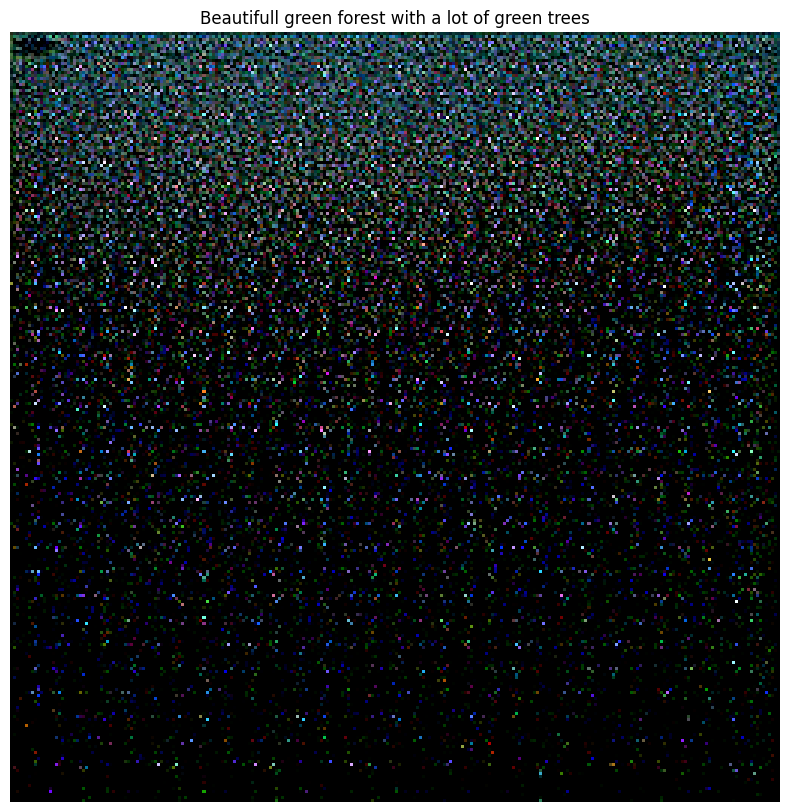

In [21]:
visualize_results(transistor_model, vqgan_model, "Beautifull green forest with a lot of green trees", config.DEVICE, encode_text)

---

In [144]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def initialize_z_from_segmentation(model, segmentation_tensor, visualize=True):
    """
    Initialize z and z_indices from a segmentation tensor.

    Args:
    model (torch.nn.Module): The VQGAN model.
    segmentation_tensor (torch.Tensor): One-hot encoded segmentation tensor [1, num_categories, height, width]
    visualize (bool): Whether to visualize the RGB representation of the segmentation.

    Returns:
    tuple: (z, z_indices)
        z (torch.Tensor): Encoded latent representation for z.
        z_indices (torch.Tensor): Indices from the quantized representation for z.
    """
    # Convert segmentation to RGB for z encoding
    segmentation_rgb = segmentation_to_rgb(segmentation_tensor)

    # Visualize the RGB representation if requested
    if visualize:
        visualize_rgb_segmentation(segmentation_rgb)

    # Encode the RGB representation to get z and z_indices
    z, _, [_, _, z_indices] = model.first_stage_model.encode(segmentation_rgb)

    print("z shape:", z.shape)
    print("z_indices shape:", z_indices.shape)

    return z, z_indices

def segmentation_to_rgb(segmentation_tensor):
    """
    Convert a one-hot encoded segmentation tensor to an RGB image.
    
    Args:
    segmentation_tensor (torch.Tensor): One-hot encoded segmentation tensor [1, num_categories, height, width]
    
    Returns:
    torch.Tensor: RGB tensor [1, 3, height, width]
    """
    # Remove batch dimension and move to CPU
    seg = segmentation_tensor.squeeze(0).cpu().numpy()
    
    # Get the index of the maximum value along the category dimension
    seg_argmax = np.argmax(seg, axis=0)
    
    # Create a color map (you might want to define specific colors for each category)
    color_map = np.random.randint(0, 256, (seg.shape[0], 3), dtype=np.uint8)
    
    # Map the segmentation to RGB
    rgb_image = color_map[seg_argmax]
    
    # Convert to torch tensor and add batch dimension
    rgb_tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    
    # Move to the same device as the model
    rgb_tensor = rgb_tensor.to(segmentation_tensor.device)
    
    return rgb_tensor

def visualize_rgb_segmentation(rgb_tensor):
    """
    Visualize the RGB representation of the segmentation.

    Args:
    rgb_tensor (torch.Tensor): RGB tensor [1, 3, height, width]
    """
    # Move tensor to CPU and convert to numpy array
    rgb_np = rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Clip values to [0, 1] range
    rgb_np = np.clip(rgb_np, 0, 1)

    # Create a new figure
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_np)
    plt.axis('off')
    plt.title('RGB Representation of Segmentation')
    plt.show()

⛳️ Number of categories in segmentation image: 256
⛳️ Segmentation tensor shape: torch.Size([1, 183, 640, 480])


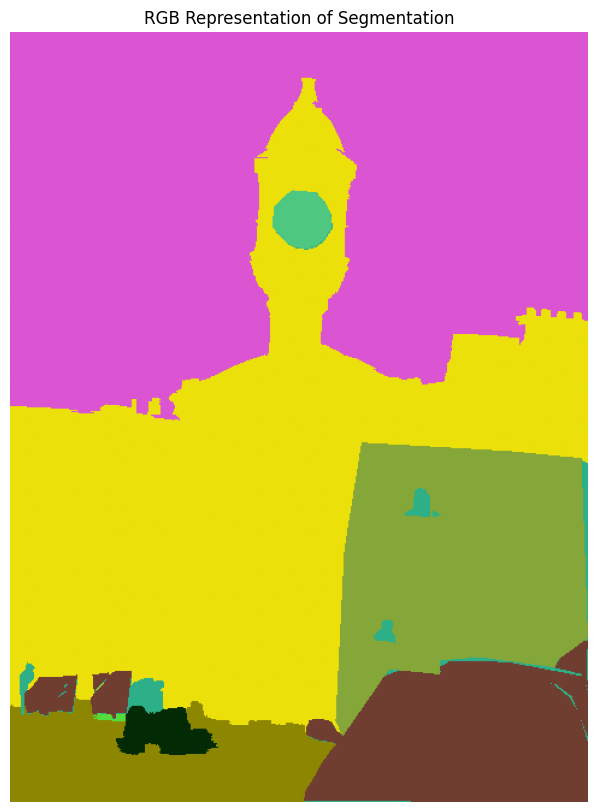

z shape: torch.Size([1, 256, 40, 30])
z_indices shape: torch.Size([1200])


In [145]:
segmentation_tensor = load_and_process_segmentation(
    config.INITIAL_IMAGE, 
    plot_segmentation=False, 
)
    
# Example usage:
z, z_indices = initialize_z_from_segmentation(vqgan_model, segmentation_tensor, visualize=True)

---

In [146]:
from functions.utils import(
    show_image
)
import config
from functions.vqgan import generate_iteration, load_and_process_segmentation

In [147]:
config.INITIAL_IMAGE = f"data/coco_segmentations/000000098392.png"

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def initialize_from_segmentation(model, segmentation_path, num_categories_expected=183, device='cuda', visualize=True):
    """
    Initialize both z and c from a segmentation mask.

    Args:
    model (torch.nn.Module): The VQGAN model.
    segmentation_path (str): Path to the segmentation image.
    num_categories_expected (int): Number of categories the model expects.
    device (str): Device to use for tensor operations.
    visualize (bool): Whether to visualize the RGB representation of the segmentation.

    Returns:
    tuple: (z, z_indices, c_code, c_indices)
        z (torch.Tensor): Encoded latent representation for z.
        z_indices (torch.Tensor): Indices from the quantized representation for z.
        c_code (torch.Tensor): Encoded conditional code.
        c_indices (torch.Tensor): Indices from the quantized representation for c.
    """
    # Load and process the segmentation mask
    segmentation_tensor = load_and_process_segmentation(
        segmentation_path,
        plot_segmentation=True,
        num_categories_expected=num_categories_expected,
        device=device
    )

    # Encode the segmentation to get c_code and c_indices
    c_code, c_indices = model.encode_to_c(segmentation_tensor)

    # Convert segmentation to RGB for z encoding
    segmentation_rgb = segmentation_to_rgb(segmentation_tensor)

    # Visualize the RGB representation if requested
    if visualize:
        visualize_rgb_segmentation(segmentation_rgb)

    # Encode the RGB representation to get z and z_indices
    z, _, [_, _, z_indices] = model.first_stage_model.encode(segmentation_rgb)

    print("z shape:", z.shape)
    print("z_indices shape:", z_indices.shape)
    print("c_code shape:", c_code.shape)
    print("c_indices shape:", c_indices.shape)

    return z, z_indices, c_code, c_indices

def segmentation_to_rgb(segmentation_tensor):
    """
    Convert a one-hot encoded segmentation tensor to an RGB image.
    
    Args:
    segmentation_tensor (torch.Tensor): One-hot encoded segmentation tensor [1, num_categories, height, width]
    
    Returns:
    torch.Tensor: RGB tensor [1, 3, height, width]
    """
    # Remove batch dimension and move to CPU
    seg = segmentation_tensor.squeeze(0).cpu().numpy()
    
    # Get the index of the maximum value along the category dimension
    seg_argmax = np.argmax(seg, axis=0)
    
    # Create a color map (you might want to define specific colors for each category)
    color_map = np.random.randint(0, 256, (seg.shape[0], 3), dtype=np.uint8)
    
    # Map the segmentation to RGB
    rgb_image = color_map[seg_argmax]
    
    # Convert to torch tensor and add batch dimension
    rgb_tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    
    # Move to the same device as the model
    rgb_tensor = rgb_tensor.to(segmentation_tensor.device)
    
    return rgb_tensor

def visualize_rgb_segmentation(rgb_tensor):
    """
    Visualize the RGB representation of the segmentation.

    Args:
    rgb_tensor (torch.Tensor): RGB tensor [1, 3, height, width]
    """
    # Move tensor to CPU and convert to numpy array
    rgb_np = rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Clip values to [0, 1] range
    rgb_np = np.clip(rgb_np, 0, 1)

    # Create a new figure
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_np)
    plt.axis('off')
    plt.title('RGB Representation of Segmentation')
    plt.show()

# Example usage:
z, z_indices, c_code, c_indices = initialize_from_segmentation(vqgan_model, config.INITIAL_IMAGE, visualize=False)

In [164]:
def generate_image_from_text(user_query, transistor_model, vqgan_model, encode_text_fn, device, n_iterations=1):
    # Encode text
    text_latent, _ = encode_text_fn([user_query])
    text_latent = text_latent.mean(dim=1).to(device)  # Average over token dimension

    # Pass through Transistor
    with torch.no_grad():
        image_latent = transistor_model(text_latent)

    # Reshape
    image_latent = image_latent.view(1, 256, 16, 16)

    # Quantize (this step depends on VQGAN's specific implementation)
    c_code, _, [_, _, c_indices] = vqgan_model.first_stage_model.quantize(image_latent)
    
    print("c_code", c_code.shape, c_code.dtype)
    print("c_indices", c_indices.shape, c_indices.dtype)

    z_indices = torch.randint(256, c_indices.shape, device=vqgan_model.device)
    initial_image = vqgan_model.decode_to_img(z_indices, c_code.shape)

    print("Initial random image:")
    show_image(initial_image)

    for iteration in range(n_iterations):
        print(f"⛳️ Starting iteration {iteration + 1}/{n_iterations}")
        final_image = generate_iteration(
            vqgan_model, 
            c_code, 
            c_indices, 
            z_indices, 
            temperature=config.TEMPERATURE, 
            top_k=config.TOP_K, 
            update_every=config.UPDATE_EVERY,
            iteration=iteration,
        )

    print("✅ All iterations completed.")


In [180]:
test1 = 'Beautifull green forest with a lot of green trees'

test2 = 'Blue ocean with blue waves'

test3 = 'Yellow beautiful flower'

🕰️ Time: 16.44 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


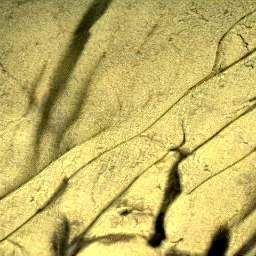

✅ All iterations completed.


In [173]:
generate_image_from_text(test1, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.59 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


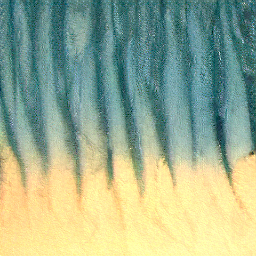

✅ All iterations completed.


In [174]:
generate_image_from_text(test2, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.61 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


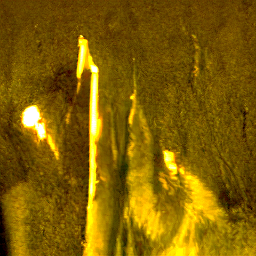

✅ All iterations completed.


In [181]:
generate_image_from_text(test3, transistor_model, vqgan_model, encode_text, config.DEVICE)

---